In [4]:
import pickle
import pandas as pd

train_data = pickle.load(open("./data/train.pkl", "rb"))
valid_data = pickle.load(open("./data/valid.pkl", "rb"))
test_data = pickle.load(open("./data/test.pkl", "rb"))

train_df = pd.concat([pd.DataFrame(train_data), pd.DataFrame(valid_data)], ignore_index=True)
test_df = pd.DataFrame(test_data)

X_train = train_df.drop(columns=["d_class"])
y_train = train_df["d_class"]
y_train, label_mapping = pd.factorize(y_train)

X_test = test_df.drop(columns=["d_class"])
y_test = test_df["d_class"]

y_test = label_mapping.get_indexer(y_test)
if (y_test == -1).any():
    raise ValueError("Test set contains unseen labels.")

In [5]:
display(train_df.describe())
display(test_df.describe())

,ax,ay,az,gx,gy,gz
count,42104.000000,42104.000000,42104.000000,42104.000000,42104.000000,42104.000000
mean,-0.405419,-9.708843,-1.761928,0.020087,-0.219457,0.087758
std,7.572023,12.196850,9.450440,2.233857,2.203372,1.637290
min,-76.860756,-78.107712,-78.690964,-12.737924,-12.893181,-9.233307
25%,-2.787690,-12.643009,-4.588745,-1.246709,-1.426736,-0.431020
50%,-0.283136,-8.604948,-0.774658,0.030359,-0.128328,0.059667
75%,2.283314,-1.961815,1.251745,1.171673,0.736742,0.613611
max,65.304916,52.677094,78.295845,12.146985,14.507542,10.520374


,ax,ay,az,gx,gy,gz
count,10517.000000,10517.000000,10517.000000,10517.000000,10517.000000,10517.000000
mean,-0.653272,-9.646185,-1.772560,0.010896,-0.197160,0.098004
std,7.887084,11.720275,9.143680,2.120880,2.289206,1.716437
min,-78.825264,-78.107712,-78.690964,-8.829717,-11.454051,-9.182176
25%,-2.648257,-13.000205,-4.586163,-1.315358,-1.427812,-0.447132
50%,-0.202679,-8.642876,-0.906581,0.058055,-0.092190,0.064099
75%,2.048490,-1.957030,1.227817,1.213567,0.790845,0.669570
max,57.553066,39.430126,78.295845,7.783258,14.100623,10.161391


# Data analysis

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_individual_sensors(df):
    """
    Plots each sensor's data in a separate subplot with lines for each d_class, 
    with all classes on top of each other using a standardized time index.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the columns ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'd_class'].
    """
    # Define sensor columns
    sensor_columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    
    # Reset the index for each class to make them align on the x-axis
    df = df.copy()  # To avoid modifying the original DataFrame
    df['time_index'] = df.groupby('d_class').cumcount()
    
    # Set up the subplot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, sensor in enumerate(sensor_columns):
        # Create a line plot for each sensor with the standardized time index
        sns.lineplot(data=df, x='time_index', y=sensor, hue='d_class', ax=axes[i])
        
        # Set title and labels
        axes[i].set_title(f'{sensor}')
        axes[i].set_ylabel('Sensor Value')
    
    # Adjust layout and display legend outside of plots
    plt.tight_layout()
    plt.legend(title='Class', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Example usage
# Assuming you have a DataFrame `data` with the specified columns
# plot_individual_sensors(data)


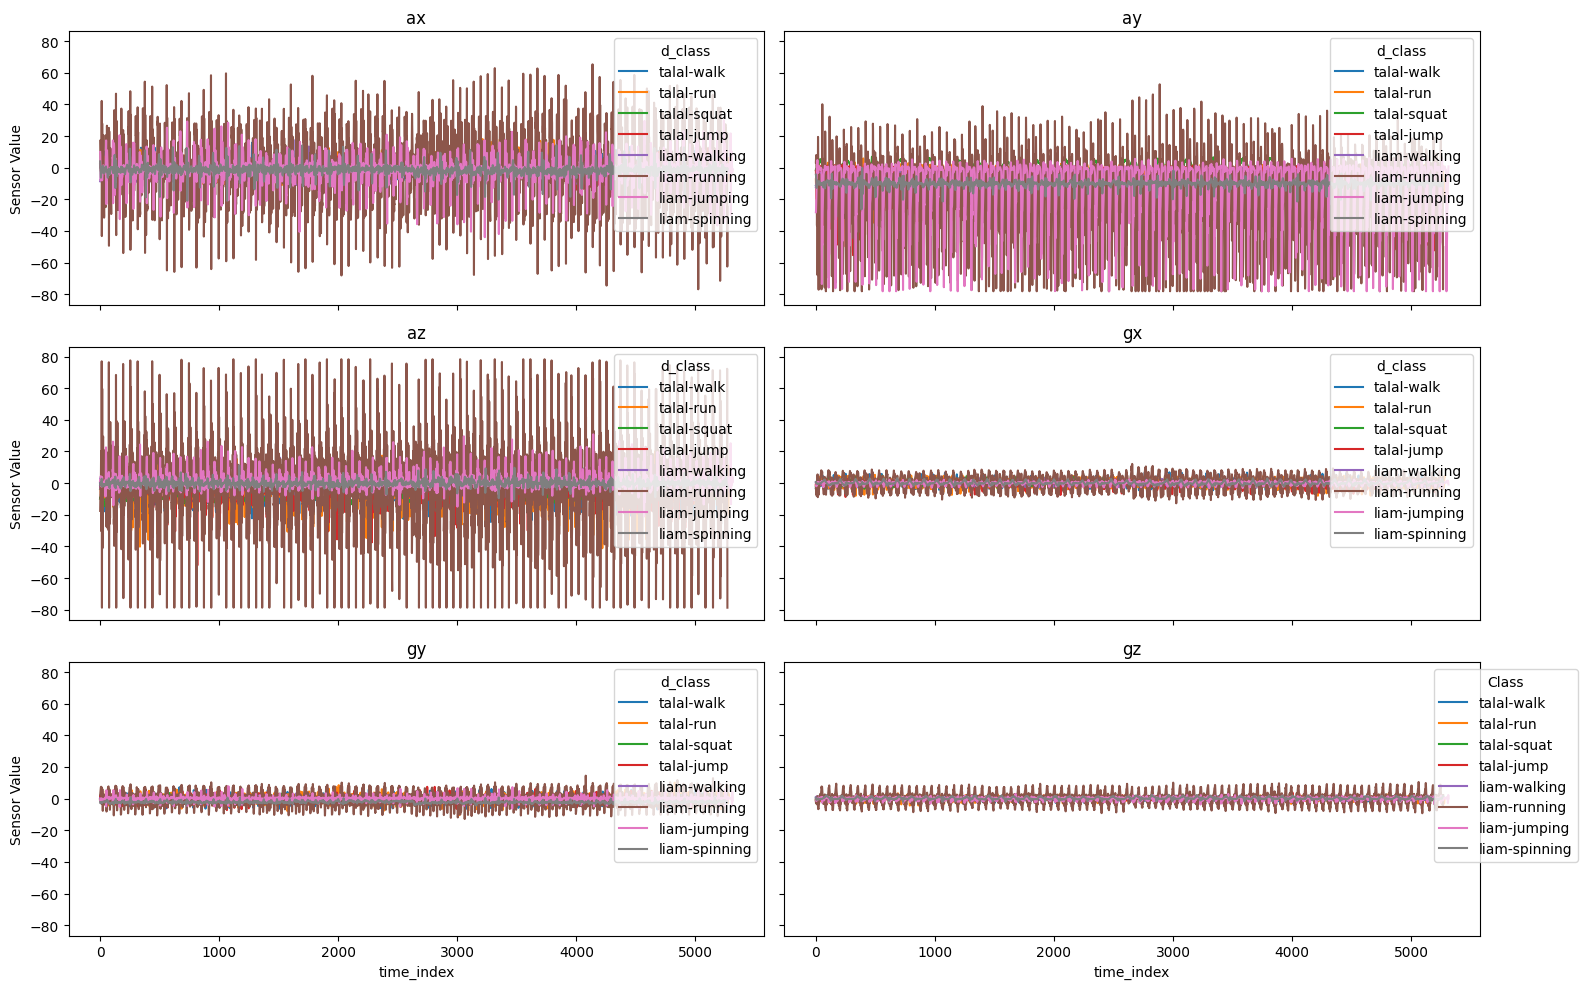

In [3]:
plot_individual_sensors(train_df)

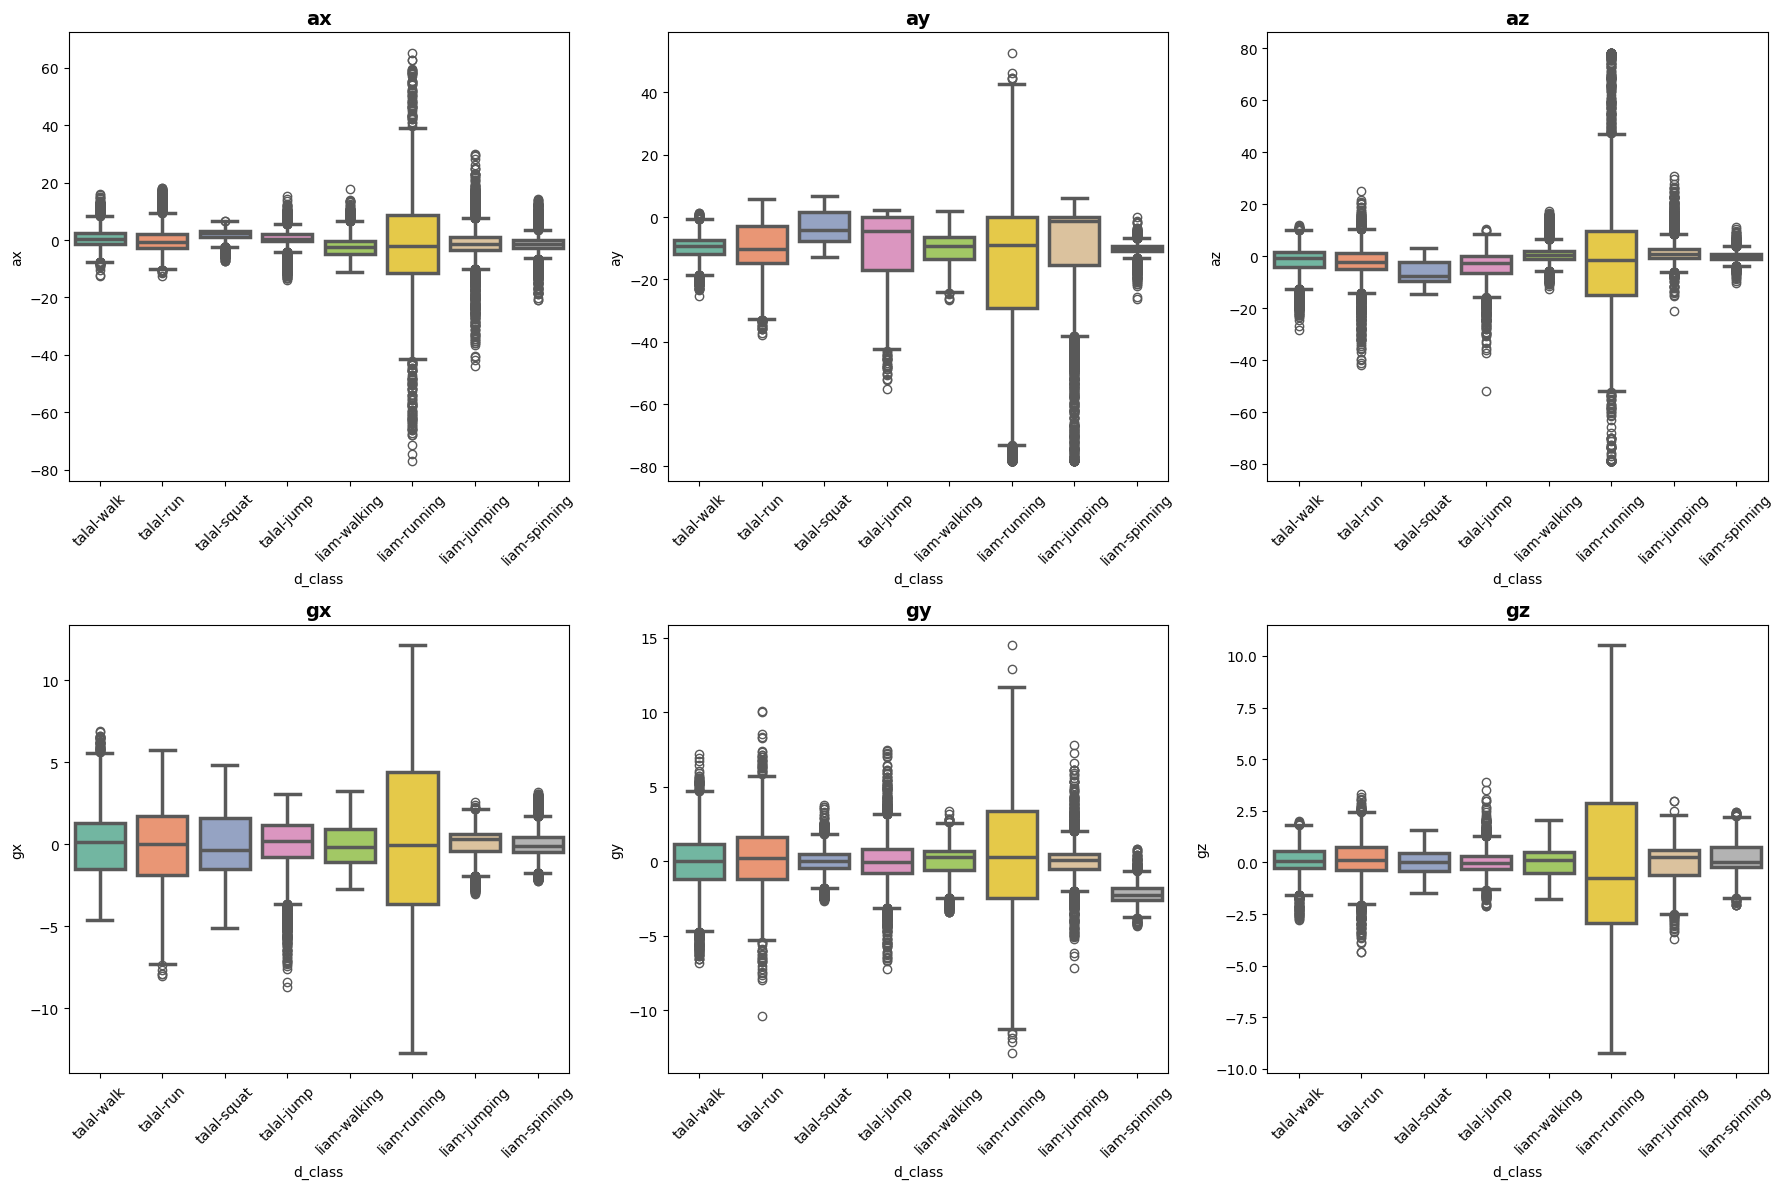

In [4]:
plotting_data = train_df

# Define the columns to plot (excluding 'd_class')
columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

# Loop through each column and create a box plot with enhancements
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid of subplots
    
    # Create a box plot with additional enhancements
    sns.boxplot(x='d_class', y=column, hue='d_class', data=plotting_data, linewidth=2.5, palette='Set2', legend=False)
    
    # Overlay a strip plot for additional data points visualization
    # sns.stripplot(x='d_class', y=column, data=plotting_data, jitter=True, size=4, color=".3", alpha=0.2)

    # Customize title and labels
    plt.xticks(rotation=45)
    plt.title(f'{column}', fontsize=14, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the final plot
plt.show()

# Model

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-10-28 21:28:42.143355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


In [6]:
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import GRU, Dense
from keras.api.optimizers import Adam
import numpy as np

In [6]:
def prepare_data_windows(data, target, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(target[i + window_size])
    return np.array(X_windows), np.array(y_windows)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras_tuner import HyperModel, Hyperband
import os
import datetime

# Define the HyperModel class
class GRUHyperModel(HyperModel):
    def build(self, hp):
        num_neurons = hp.Choice('num_neurons', [32, 64, 128])
        num_layers = hp.Choice('num_layers', [1, 2])
        window_size = hp.Choice('window_size', [50, 100, 150])
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

        model = Sequential()
        for _ in range(0, num_layers - 1):
            model.add(GRU(num_neurons, activation='tanh', return_sequences=True, input_shape=(window_size, 6)))
            model.add(Dropout(dropout_rate)) 

        model.add(GRU(num_neurons, activation='tanh'))
        model.add(Dropout(dropout_rate))  
        model.add(Dense(10, activation='softmax'))  

        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
        return model

# Create the HyperModel instance
hypermodel = GRUHyperModel()

# Initialize Keras Tuner with Hyperband
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,  # Maximum number of epochs to train each model
    hyperband_iterations=2,  # Number of Hyperband iterations
    directory='tuner_dir',
    project_name='gru_tuning',
    overwrite=True
)

# Create a directory for TensorBoard logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the ModelCheckpoint callback
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model-{epoch}-{val_accuracy:.5f}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Run the hyperparameter search
X_windows, y_windows = prepare_data_windows(X_train, y_train, 150)

tuner.search(X_windows, y_windows, epochs=10, validation_split=0.2, 
             callbacks=[tensorboard_callback, checkpoint_callback], verbose=2)

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Num Neurons: {best_hyperparameters.get('num_neurons')}")
print(f"Num Layers: {best_hyperparameters.get('num_layers')}")
print(f"Window Size: {best_hyperparameters.get('window_size')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout_rate')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")


Trial 60 Complete [00h 17m 03s]
val_accuracy: 0.9829579591751099

Best val_accuracy So Far: 0.9911810159683228
Total elapsed time: 03h 55m 43s
Best Hyperparameters:
Num Neurons: 64
Num Layers: 2
Window Size: 50
Dropout Rate: 0.1
Learning Rate: 0.0018524316172664496


In [12]:
import pickle

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=5)
pickle.dump(best_hyperparameters, open("best_models/params.pkl", "wb"))

for i, model in enumerate(tuner.get_best_models(num_models=5)):
    model.save(f"best_models/best_{i}.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluate

In [34]:
import pickle

best_model_params = pickle.load(open("best_models/params.pkl", "rb"))

for i, param in enumerate(best_model_params):
    print(f"Model no.{i + 1} params:")
    print(best_model_params[i].values)

Model no.1 params:
{'num_neurons': 64, 'num_layers': 2, 'window_size': 50, 'dropout_rate': 0.1, 'learning_rate': 0.0018524316172664496, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Model no.2 params:
{'num_neurons': 64, 'num_layers': 2, 'window_size': 50, 'dropout_rate': 0.1, 'learning_rate': 0.0018524316172664496, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0048'}
Model no.3 params:
{'num_neurons': 32, 'num_layers': 2, 'window_size': 100, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0010910921910059672, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0051'}
Model no.4 params:
{'num_neurons': 32, 'num_layers': 2, 'window_size': 100, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0010910921910059672, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Model no.5 params:
{'num_neurons': 1

In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

X_test_windows, y_test_windows = prepare_data_windows(X_test, y_test, 50)
best_model = load_model("./best_models/best_0.keras")

y_pred_probs = best_model.predict(X_test_windows)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Print classification report
print(classification_report(y_test_windows, y_pred_classes, target_names=label_mapping.to_list(), digits=4))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
               precision    recall  f1-score   support

   talal-walk     0.9603    0.9992    0.9794      1259
    talal-run     0.9674    0.9674    0.9674      1321
  talal-squat     0.9977    0.9794    0.9884      1308
   talal-jump     0.9901    0.9923    0.9912      1307
 liam-walking     0.9923    0.9795    0.9859      1319
 liam-running     0.9932    0.9932    0.9932      1318
 liam-jumping     0.9947    0.9932    0.9939      1316
liam-spinning     1.0000    0.9917    0.9958      1319

     accuracy                         0.9869     10467
    macro avg     0.9870    0.9870    0.9869     10467
 weighted avg     0.9871    0.9869    0.9869     10467



328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


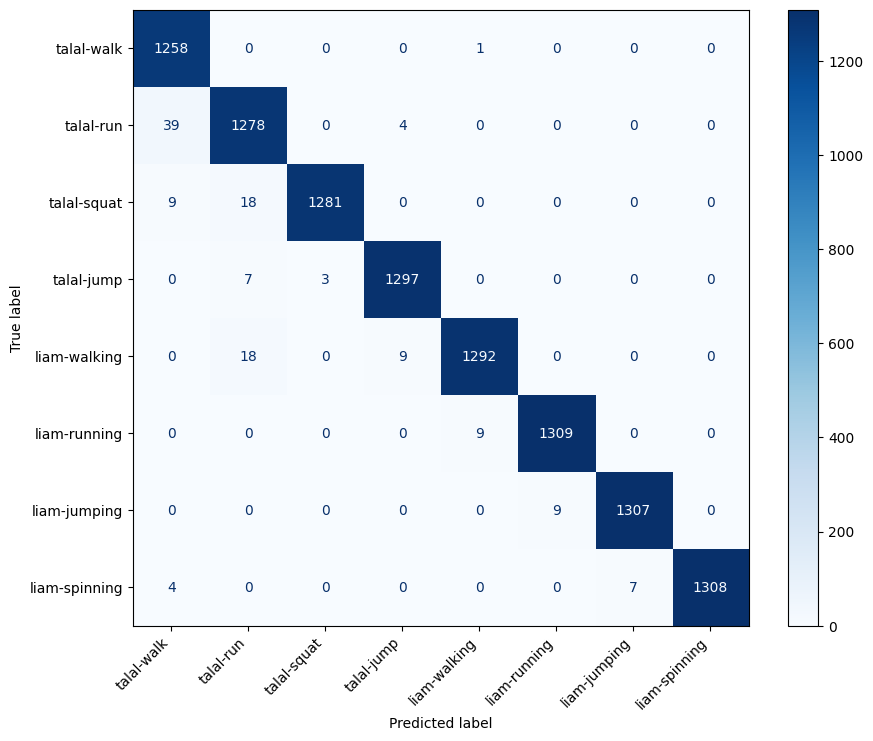

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_mapping is your list of label names (from pd.factorize or similar)
y_pred_best = best_model.predict(X_test_windows)
cm_best = confusion_matrix(y_test_windows, np.argmax(y_pred_best, axis=1))

# Create the ConfusionMatrixDisplay
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=label_mapping)

# Plot and rotate x-axis labels after plot
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if needed
disp_best.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Keep y-axis labels straight

plt.show()


# Testing on continuous different movements in one recording

In [14]:
import pickle
import pandas as pd

continuous_test = pickle.load(open("data/continuous-end-test/combined.pkl", "rb"))

positions = [0, 0.28, 0.48, 0.70, 1.0]
labels = ["liam-running", "liam-walking", "liam-spinning", "liam-jumping"]

bins = [int(len(continuous_test) * pos) for pos in positions]
bins[-1] = len(continuous_test)

continuous_test['d_class'] = pd.cut(
    continuous_test.index, 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

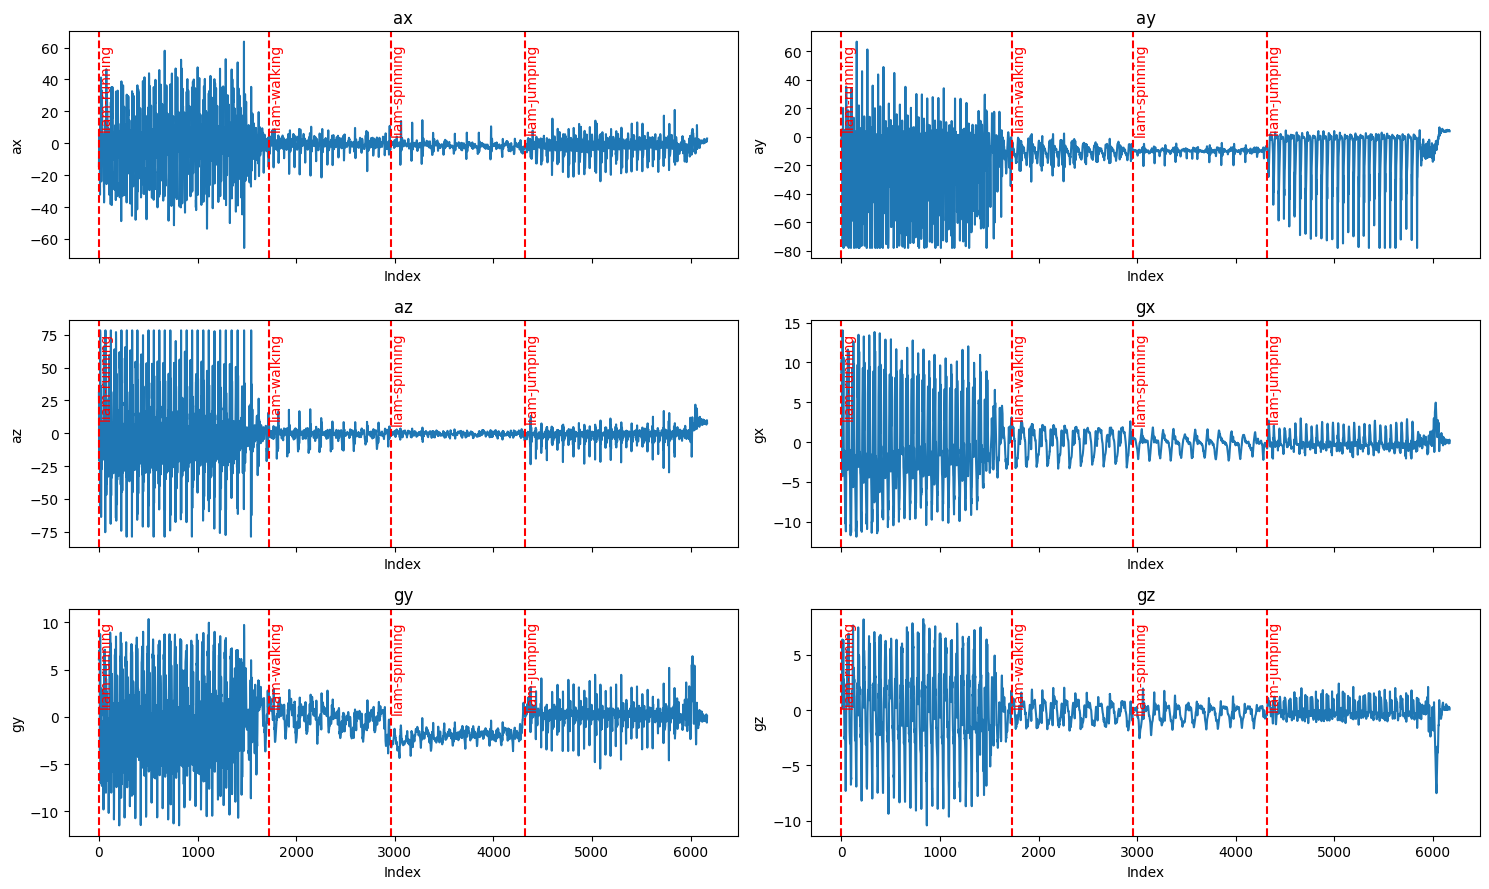

In [15]:
import seaborn as sb
import matplotlib.pyplot as plt

columns = continuous_test.columns
num_columns = len(columns)

fig_cols = 2
nrows = 3

# Create subplots
# figsize: size of figure in inches (width, height)
fig, axes = plt.subplots(nrows=nrows, ncols=fig_cols, figsize=(15, nrows * 3), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each column in its respective subplot
for i, col in enumerate(columns[:-1]):
    axes[i].plot(continuous_test[col])

    # Add vertical lines and labels
    for bin_edge, label in zip(bins[:-1], labels):
        axes[i].axvline(x=bin_edge, color='red', linestyle='--')
        y_min, y_max = axes[i].get_ylim()
        y_pos = y_max - (y_max - y_min) * 0.05  # Position label near the top
        axes[i].text(bin_edge, y_pos, label, rotation=90, verticalalignment='top', color='red')

    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import load_model
import numpy as np

best_model = load_model("best_models/best_0.keras")

X, y = continuous_test.drop(columns=["d_class"]), continuous_test["d_class"]
y = label_mapping.get_indexer(y)
if (y == -1).any():
    raise ValueError("Test set contains unseen labels.")

def prepare_data_windows(data, target, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(target[i + window_size])
    return np.array(X_windows), np.array(y_windows)

X_windows, y_windows = prepare_data_windows(X, y, 50)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
# Make predictions
predictions = best_model.predict(X_windows)

# If the model outputs probabilities, take the argmax to get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Confidence scores (max probability for each prediction)
correct_class_confidence_scores = predictions[np.arange(len(predictions)), y_windows]

# Calculate correctness of each prediction
correctness = (predicted_classes == y_windows).astype(int)

# Calculate cumulative accuracy up to each point
cumulative_accuracy = np.cumsum(correctness) / (np.arange(1, len(correctness) + 1))


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


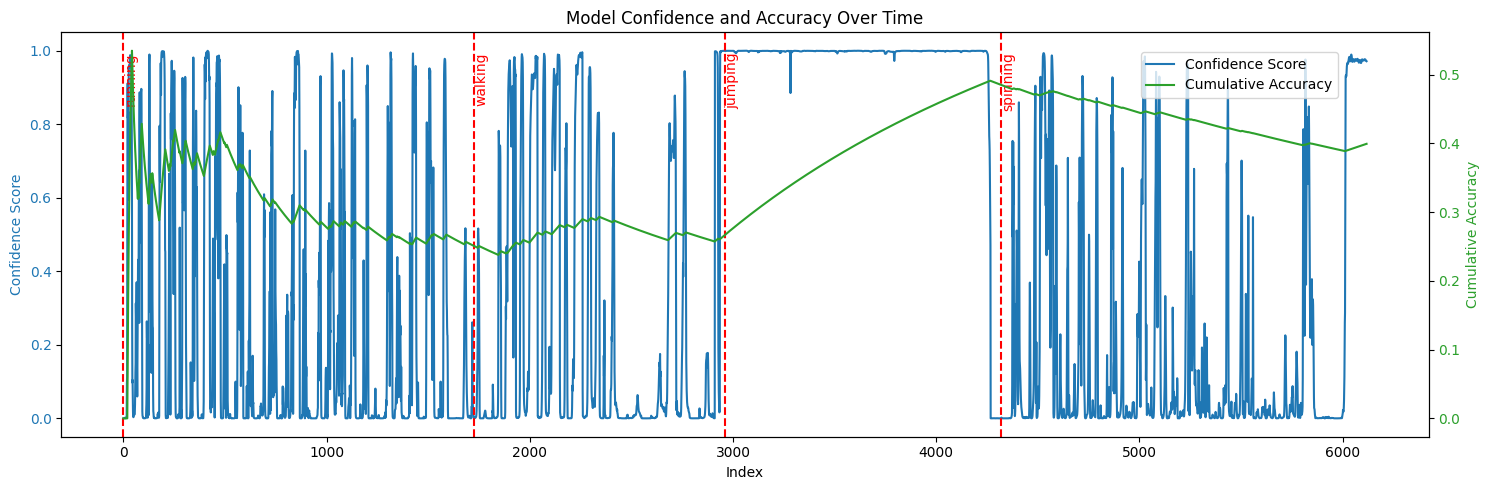

In [59]:
# Define positions for vertical lines based on earlier code
positions = [0, 0.28, 0.48, 0.70, 1.0]
N = len(continuous_test)
bins = [int(N * pos) for pos in positions]
bins[-1] = N

# Plot confidence scores and cumulative accuracy
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Confidence Score', color=color)
ax1.plot(correct_class_confidence_scores, color=color, label='Confidence Score')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for cumulative accuracy
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Cumulative Accuracy', color=color)
ax2.plot(cumulative_accuracy, color=color, label='Cumulative Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical lines and labels
for bin_edge, label in zip(bins[:-1], labels):
    ax1.axvline(x=bin_edge, color='red', linestyle='--')
    y_min, y_max = ax1.get_ylim()
    y_pos = y_max - (y_max - y_min) * 0.05
    ax1.text(bin_edge, y_pos, label, rotation=90, verticalalignment='top', color='red')

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Adjust layout
plt.title('Model Confidence and Accuracy Over Time')
plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import classification_report

unique_classes = [i for i in range(len(label_mapping))]
print(classification_report(y_windows, predicted_classes, labels=unique_classes, target_names=label_mapping, zero_division=np.nan))

               precision    recall  f1-score   support

   talal-walk       0.00       nan      0.00         0
    talal-run       0.00       nan      0.00         0
  talal-squat        nan       nan       nan         0
   talal-jump       0.00       nan      0.00         0
 liam-walking       0.39      0.26      0.31      1234
 liam-running       0.78      0.25      0.38      1677
 liam-jumping       0.88      0.19      0.31      1851
liam-spinning       0.88      0.99      0.93      1357

     accuracy                           0.40      6119
    macro avg       0.42      0.42      0.28      6119
 weighted avg       0.75      0.40      0.47      6119



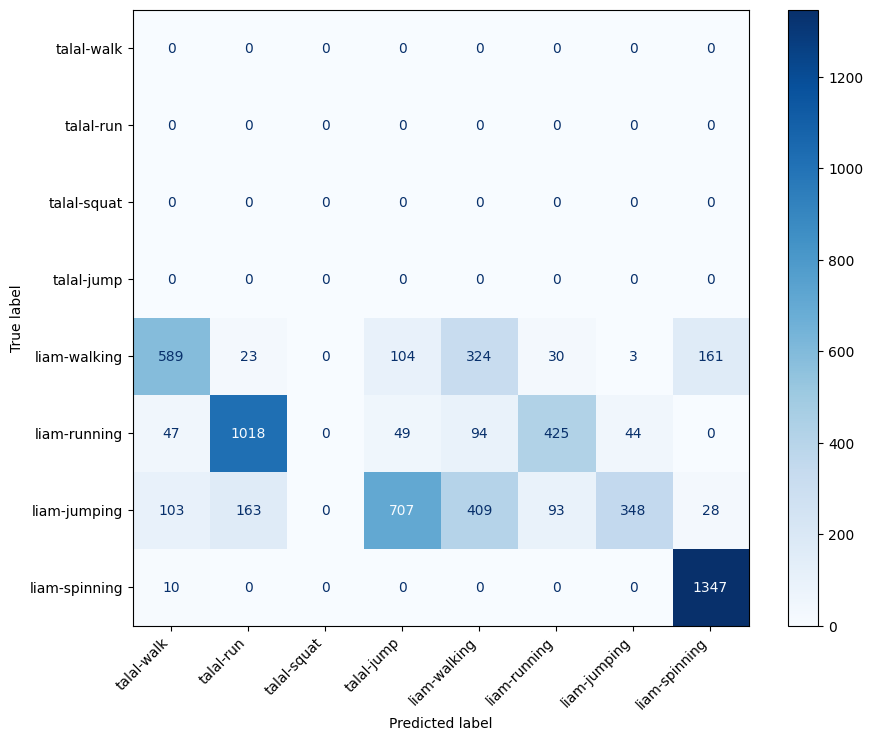

In [20]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_windows, predicted_classes, labels=np.arange(8))

# Create the ConfusionMatrixDisplay
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping)

# Plot and rotate x-axis labels after plot
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if needed
disp_best.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Keep y-axis labels straight

plt.show()


Calculating accuracy for non-person agnostic

               precision    recall  f1-score   support

   talal-walk        nan       nan       nan         0
    talal-run        nan       nan       nan         0
  talal-squat        nan       nan       nan         0
   talal-jump        nan       nan       nan         0
 liam-walking       0.58      0.74      0.65      1234
 liam-running       0.82      0.86      0.84      1677
 liam-jumping       0.84      0.57      0.68      1851
liam-spinning       0.88      0.99      0.93      1357

     accuracy                           0.78      6119
    macro avg       0.78      0.79      0.78      6119
 weighted avg       0.79      0.78      0.77      6119



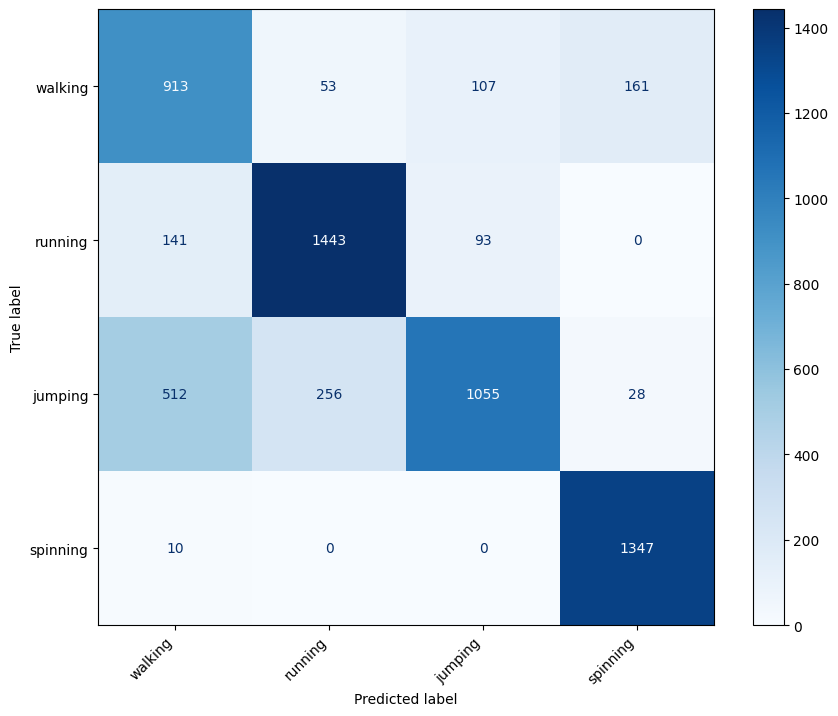

In [24]:
pred_non_person = predicted_classes
y_windows_non_person = y_windows

# # Create a mapping dictionary for "talal-*" to "liam-*"
label_mapping_mapping = {
    "talal-walk": "liam-walking",
    "talal-run": "liam-running",
    "talal-jump": "liam-jumping"
}

# Convert the mapping dictionary to indices
for talal_label, liam_label in label_mapping_mapping.items():
    y_windows_non_person[y_windows_non_person == label_mapping.get_indexer([talal_label])[0]] = label_mapping.get_indexer([liam_label])[0]
    pred_non_person[pred_non_person == label_mapping.get_indexer([talal_label])[0]] = label_mapping.get_indexer([liam_label])[0]

from sklearn.metrics import classification_report

unique_classes = [i for i in range(len(label_mapping))]
print(classification_report(y_windows_non_person, pred_non_person, labels=unique_classes, target_names=label_mapping, zero_division=np.nan))

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_windows_non_person, pred_non_person, labels=np.arange(4, 8))
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["walking", "running", "jumping", "spinning"])

# Plot and rotate x-axis labels after plot
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if needed
disp_cm.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Keep y-axis labels straight

plt.show()
